Links:
* [h3 edges](https://h3geo.org/docs/highlights/aggregation)


## Initial setup

In [1]:
from shapely.geometry import Point, Polygon, GeometryCollection, shape
from datetime import datetime
import h3.api.numpy_int as h3
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
import branca
import geojson
from route3_client import Server

server = Server(hostport="127.0.0.1:7088")

def dataframe_to_geodataframe(df: pd.DataFrame, column_name: str = "h3index") -> gpd.GeoDataFrame:
    return gpd.GeoDataFrame(df,
                            geometry=[Polygon(h3.h3_to_geo_boundary(h, geo_json=True)) for h in
                                      np.nditer(df[column_name].to_numpy())],
                            crs=4326)


# test POIs - fast food shops. Can be created using the top-level justfile
poi_df = gpd.read_file("../data/hospital.geojson")
del poi_df['@id']
print(f"Using {len(poi_df)} POI locations")

poi_df

Using 601 POI locations


name   amenity  \
0                    Kreiskrankenhaus Torgau  hospital   
1                  Haupteingang Moltkestraße      None   
2                     Diakonissenkrankenhaus  hospital   
3            Stiftungskrankenhaus Nördlingen  hospital   
4                        Medizinische Klinik  hospital   
..                                       ...       ...   
596                                Obersburg  hospital   
597                   Klinikum Lippe-Detmold  hospital   
598  PhysioSport Performance Athletic Center  hospital   
599                              Notaufnahme  hospital   
600           Sana Klinik Bethesda Stuttgart  hospital   

                      geometry  
0    POINT (12.98463 51.56156)  
1     POINT (8.37468 49.01561)  
2     POINT (8.40941 48.97196)  
3    POINT (10.49856 48.83709)  
4    POINT (11.56182 48.13225)  
..                         ...  
596   POINT (9.24213 52.22437)  
597   POINT (8.88041 51.94011)  
598   POINT (7.01584 50.97098)  
599   POINT (8.35409 52.05490)  
600   POINT (9.18800 48.77201)  

[601 rows x 3 columns]

## Create a disturbance which hinders traffic

You can use [geojson.io](http://geojson.io) to draw a featurecollection and paste it into the string bellow.

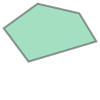

In [18]:
disturbance_geojson_string = """
{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              9.252548217773438,
              47.71865494762469
            ],
            [
              9.248085021972656,
              47.71542115780128
            ],
            [
              9.251346588134766,
              47.71103212201742
            ],
            [
              9.260272979736328,
              47.71368868783623
            ],
            [
              9.258041381835938,
              47.71738455412987
            ],
            [
              9.252548217773438,
              47.71865494762469
            ]
          ]
        ]
      }
    }
  ]
}
"""


disturbance = GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in geojson.loads(disturbance_geojson_string)["features"]])
disturbance

## Route and Analyze

In [21]:
t_start = datetime.now()
dopm_id, dopm_df = server.analyze_disturbance_of_population_movement(
    disturbance, 
    25000.0, 
    poi_df.geometry.centroid, 
    num_destinations_to_reach=2
)
print(f"took {datetime.now() - t_start}")
print(f"id: {dopm_id}")
#print(f"population within disturbance: {stats.population_within_disturbance}")
geo_df = dataframe_to_geodataframe(dopm_df, column_name="h3index_origin")

geo_df["cost_increase"] = geo_df["avg_cost_with_disturbance"] - geo_df["avg_cost_without_disturbance"]
geo_df

/tmp/ipykernel_4779/2010859249.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  poi_df.geometry.centroid,


took 0:00:44.109145
id: c56d6b29-1c19-404f-a590-bbfc8a0027a6


h3index_origin  preferred_dest_h3index_without_disturbance  \
0     622051900456599551                                6.220519e+17   
1     622051900582100991                                6.220519e+17   
2     622051900845883391                                6.220519e+17   
3     622051900460466175                                6.220519e+17   
4     622051899200274431                                6.220510e+17   
...                  ...                                         ...   
8005  622051899201519615                                6.220510e+17   
8006  622051904566198271                                6.220519e+17   
8007  622051904890568703                                6.220518e+17   
8008  622051899508064255                                6.220519e+17   
8009  622051905116274687                                6.220518e+17   

      preferred_dest_h3index_with_disturbance  population_origin  \
0                                6.220519e+17          21.660061   
1                                6.220519e+17           3.864408   
2                                6.220519e+17           2.576272   
3                                6.220519e+17          21.660061   
4                                6.220510e+17          39.192673   
...                                       ...                ...   
8005                             6.220510e+17          23.515604   
8006                             6.220519e+17          33.930317   
8007                             6.220518e+17          32.048084   
8008                             6.220519e+17         120.741692   
8009                             6.220518e+17          19.399282   

      num_reached_without_disturbance  num_reached_with_disturbance  \
0                                   2                             2   
1                                   2                             2   
2                                   2                             2   
3                                   2                             2   
4                                   2                             2   
...                               ...                           ...   
8005                                2                             2   
8006                                2                             2   
8007                                2                             2   
8008                                2                             2   
8009                                2                             2   

      avg_cost_without_disturbance  avg_cost_with_disturbance  \
0                            730.5                      730.5   
1                            814.5                      814.5   
2                            736.5                      736.5   
3                            757.5                      757.5   
4                           1425.5                     1425.5   
...                            ...                        ...   
8005                        1370.5                     1370.5   
8006                        1138.5                     1138.5   
8007                         944.0                      944.0   
8008                        1009.0                     1044.5   
8009                        1136.0                     1136.0   

                                               geometry  cost_increase  
0     POLYGON ((9.44524 47.70121, 9.44499 47.70056, ...            0.0  
1     POLYGON ((9.40766 47.79269, 9.40740 47.79204, ...            0.0  
2     POLYGON ((9.38453 47.77924, 9.38427 47.77859, ...            0.0  
3     POLYGON ((9.44108 47.68845, 9.44082 47.68780, ...            0.0  
4     POLYGON ((9.19891 47.67358, 9.19866 47.67293, ...            0.0  
...                                                 ...            ...  
8005  POLYGON ((9.17940 47.66679, 9.17914 47.66615, ...            0.0  
8006  POLYGON ((9.29260 47.80999, 9.29234 47.80934, ...            0.0  
8007  POLYGON ((9.25941 47.91290, 9.2

... now map it ...

In [22]:
map_content_disolved = geo_df.dissolve().geometry[0].convex_hull
map_center = map_content_disolved.centroid

m = folium.Map(location=[map_center.y, map_center.x], zoom_start=11, tiles='OpenStreetMap', 
               #crs="EPSG4326"
              )

poi_df_subset = poi_df.loc[poi_df.geometry.within(map_content_disolved.buffer(0.8))]

folium.GeoJson(
    # use only a subset of the POIs to speed up rendering
    poi_df_subset,
    style_function=lambda x: {
        'fillColor': "#c00", 
        'color' : '#800',
        'weight' : 1,
        'fillOpacity' : 0.3,
    },
    tooltip=folium.features.GeoJsonTooltip([
        "name",
    ])
    ).add_to(m) 

folium.GeoJson(
    disturbance,
    style_function=lambda x: {
        'fillColor': "#c00", 
        'color' : '#800',
        'weight' : 1,
        'fillOpacity' : 0.3,
    },
    ).add_to(m)    
    

colorscale_cell_worsen = branca.colormap.LinearColormap(
    ((1.,1.,1.), (0.0,0.0,1.0)), 
    vmin=0.0, 
    vmax=geo_df['cost_increase'].max()
) 
   
def style_cell(feature):
    cost_inc = feature['properties']['cost_increase'] 
    if cost_inc is None:
        fill = '#f00' # no route found
    else: 
        fill = colorscale_cell_worsen(cost_inc)
    return {
        'fillColor': fill, 
        'color' : '#555',
        'weight' : 1,
        'fillOpacity' : 0.8,
    }

folium.GeoJson(
    geo_df,
    style_function=style_cell,
    tooltip=folium.features.GeoJsonTooltip([
        "h3index_origin",
        "avg_cost_without_disturbance",
        "avg_cost_with_disturbance",
        "cost_increase",
        "population_origin", 
        "preferred_dest_h3index_without_disturbance", 
        "preferred_dest_h3index_with_disturbance",
        "num_reached_without_disturbance",
        "num_reached_with_disturbance",
    ])
    ).add_to(m)    
    
m

In [ ]:
#some_cells = list(geo_df[(geo_df["avg_cost_without_disturbance"] < geo_df["avg_cost_with_disturbance"])].h3index_origin)[:400]
#some_cells = list(geo_df[(geo_df["cost_increase"] == geo_df.cost_increase.min()) ].h3index_origin)[:10]
#some_cells = [622051486772264959, ]
#some_cells = [622051491001630719, ]
#some_cells = list(geo_df[(geo_df["cost_increase"] == 214 ) & (geo_df["avg_cost_with_disturbance"] == 885)].h3index_origin)
some_cells = list(geo_df.h3index_origin)[:40]

route_gdf = server.get_disturbance_of_population_movement_routes(dopm_id, some_cells)
len(route_gdf)
route_gdf

In [ ]:

def style_route(feature):
    if feature['properties']['with_disturbance']:
        color = '#f00'
    else: 
        color = "#0f0"
    return { 
        'color' : color,
        'weight' : 2,
    }

folium.GeoJson(
    route_gdf, #[route_gdf['with_disturbance'] == 0],
    style_function=style_route,
    tooltip=folium.features.GeoJsonTooltip([
        "h3index_origin",
        "h3index_destination",
        "cost",
    ])
    ).add_to(m)    
    
m

## Retrieve results again using the ID

In [ ]:
server.get_disturbance_of_population_movement(dopm_id)